In [45]:
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from notebooks import utils
%matplotlib inline

In [1]:
sqlContext = SQLContext(sc)
df = sqlContext.read.load('file:////home/cloudera/Desktop/bigdatastudy/big-data-4/minute_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [2]:
df.count()

1587257

In [37]:
filteredDF = df.filter((df.rowID%10)==0)
filteredDF.count()
filteredDF5 = df.filter((df.rowID%5)==0)
filteredDF5.count()

317452

In [6]:
filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
air_pressure,158726,916.8301614102434,3.051716552830638,905.0,929.5
air_temp,158726,61.851589153636304,11.833569210641757,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905898,0.0,359.0
avg_wind_speed,158680,2.775214897907747,2.057623969742642,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838689,0.0,359.0
max_wind_speed,158680,3.400557726241518,2.4188016208098886,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784567,0.0,359.0
min_wind_speed,158680,2.1346641038568754,1.7421125052424393,0.0,31.6


In [9]:
filteredDF.filter(filteredDF.rain_accumulation == 0.0 ).count()

157812

In [10]:
filteredDF.filter(filteredDF.rain_duration == 0.0 ).count()

157237

In [11]:
workingDF = filteredDF.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')

In [12]:
before=workingDF.count()
workingDF=workingDF.na.drop()
after=workingDF.count()
before-after

46

In [46]:
workingDF.stat.corr('min_wind_speed', 'avg_wind_speed')

0.9708621148272599

In [14]:
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

In [17]:
featuresUsed = ['air_pressure','air_temp','avg_wind_direction','avg_wind_speed','max_wind_direction','max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed,outputCol='features_unscaled')
assembled =assembler.transform(workingDF)

In [21]:
scalar = StandardScaler(inputCol="features_unscaled",outputCol="features",withStd=True,withMean=True)
scalarModel = scalar.fit(assembled)
scaledData = scalarModel.transform(assembled)

In [23]:
scaledData = scaledData.select("features","rowID")
elbowSet = scaledData.filter((scaledData.rowID%3)==0).select("features")
elbowSet.persist()

DataFrame[features: vector]

In [24]:
clusters = range(2,31)
wsseList = utils.elbow(elbowSet,clusters)

Training for cluster size 2 
......................WSSE = 114993.13181214454 
Training for cluster size 3 
......................WSSE = 104181.0978581738 
Training for cluster size 4 
......................WSSE = 94577.27151288436 
Training for cluster size 5 
......................WSSE = 87993.46098415818 
Training for cluster size 6 
......................WSSE = 85084.23922296542 
Training for cluster size 7 
......................WSSE = 81664.96024487517 
Training for cluster size 8 
......................WSSE = 78397.76745113655 
Training for cluster size 9 
......................WSSE = 76599.60815784344 
Training for cluster size 10 
......................WSSE = 74023.93930498546 
Training for cluster size 11 
......................WSSE = 72772.61056038193 
Training for cluster size 12 
......................WSSE = 70281.81723912072 
Training for cluster size 13 
......................WSSE = 69473.53243631397 
Training for cluster size 14 
......................WSSE = 68756.123291

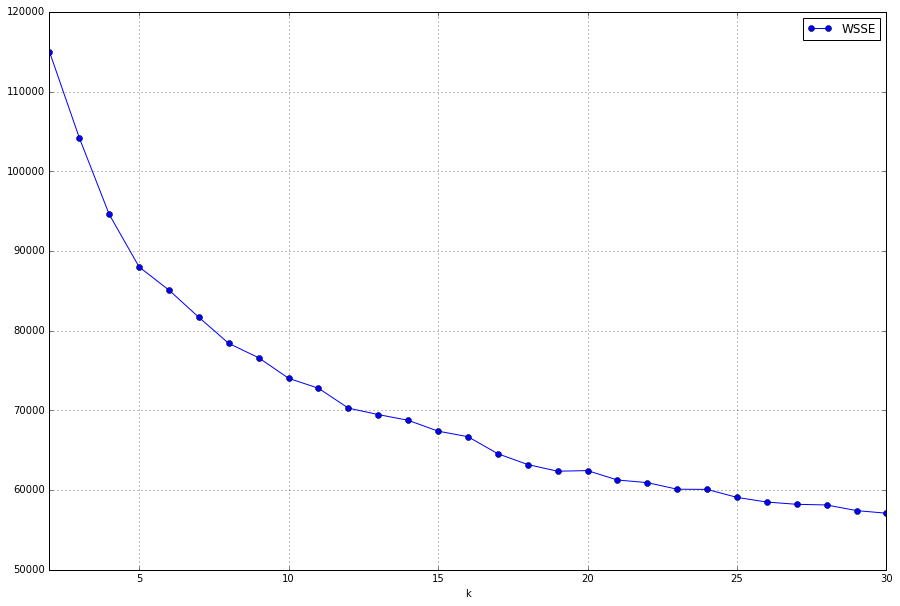

In [25]:
utils.elbow_plot(wsseList,clusters)

In [27]:
scaledDataSet = scaledData.select("features")
scaledDataSet.persist()

DataFrame[features: vector]

In [38]:
kmeans = KMeans(k=20,seed=1)
model = kmeans.fit(scaledDataSet)
transformed = model.transform(scaledDataSet)

In [39]:
centers = model.clusterCenters()
centers

[array([-0.83981371, -0.15722835,  0.45677248,  1.66719716,  0.53773469,
         1.59591307,  0.2320302 ]),
 array([ 1.24855842, -0.97733363, -1.2926491 , -0.5038991 , -1.13732659,
        -0.50899898,  0.42262184]),
 array([-1.836545  , -1.39012854,  0.39879547,  3.16298379,  0.48657869,
         3.10579576,  1.47485229]),
 array([ 0.32897594, -1.09184129,  1.27209305, -0.59060207,  1.55960843,
        -0.52526953,  1.11801273]),
 array([-1.28998389, -1.05895456,  0.36933732,  0.11511323,  0.46356054,
         0.11174136,  1.30954421]),
 array([-0.59270225,  0.65334454,  0.18596774, -0.65062076,  0.35756438,
        -0.66715743, -0.29405518]),
 array([-0.20836792,  1.17097712, -1.33441829, -0.577544  , -1.18073314,
        -0.58597431, -0.84635169]),
 array([ 0.24429517,  0.36916242,  1.89125163, -0.65004271, -1.55350503,
        -0.5758593 , -0.33656513]),
 array([ 0.37340608, -1.11279756,  0.41994128,  0.35183269,  0.49113258,
         0.32578092,  1.16887259]),
 array([ 1.17406259

In [40]:
P = utils.pd_centers(featuresUsed,centers)

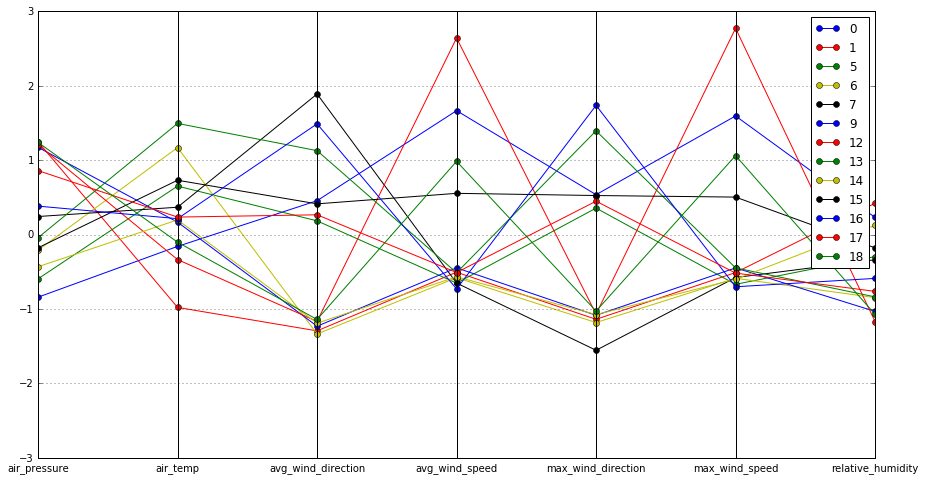

In [41]:
utils.parallel_plot(P[P['relative_humidity']<0.5],P)

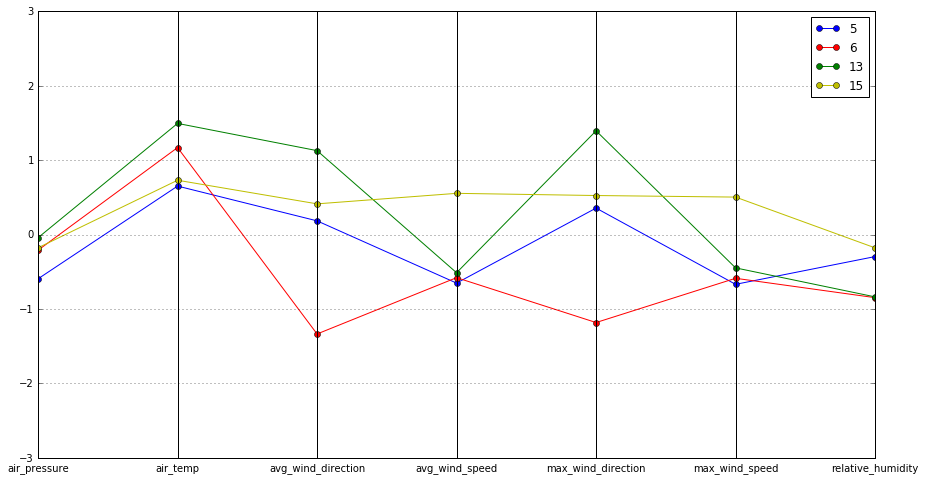

In [42]:
utils.parallel_plot(P[P['air_temp']>0.5],P)

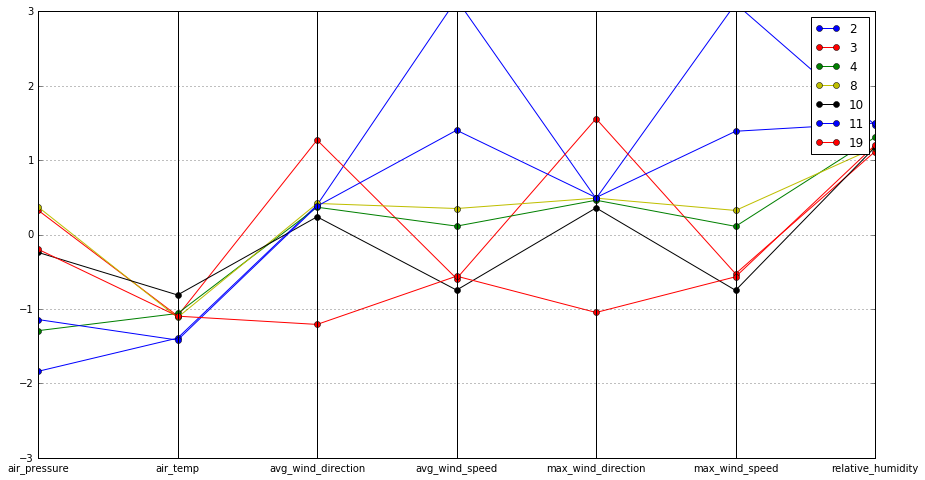

In [43]:
utils.parallel_plot(P[(P['relative_humidity']>0.5) & (P['air_temp']<0.5)],P)

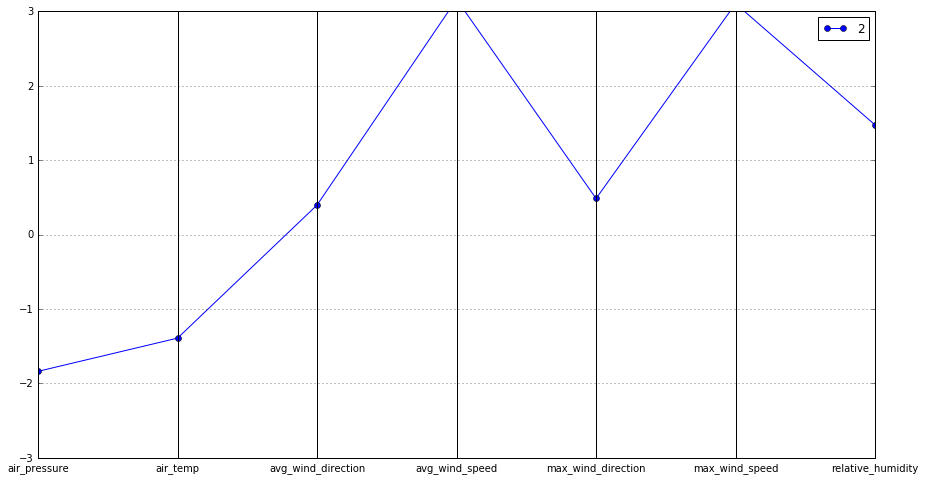

In [44]:
utils.parallel_plot(P.iloc[[2]],P)